In [0]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0

In [0]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
import tensorflow as tf

Using TensorFlow backend.


In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_images.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_images.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [0]:
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5, 1.0, '(Label: E)')

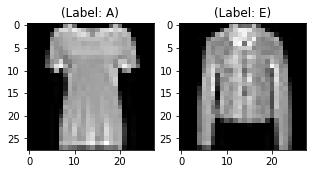

In [0]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_images[10], (28,28))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_images[10], (28,28))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [0]:
train_data = train_images.reshape(-1, 28,28, 1).astype(np.float32)
test_data = test_images.reshape(-1, 28,28, 1).astype(np.float32)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [0]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [0]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [0]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [0]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [0]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [0]:
batch_size = 64
epochs = 10
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [0]:
def encoder(input_img):
    
    conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((3,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [0]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_73 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_74 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 14, 14, 64)        1849

In [0]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 68s 1ms/step - loss: 0.0191 - val_loss: 0.0137
Epoch 2/10
48000/48000 [==============================] - 63s 1ms/step - loss: 0.0086 - val_loss: 0.0073
Epoch 3/10
48000/48000 [==============================] - 59s 1ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 4/10
48000/48000 [==============================] - 59s 1ms/step - loss: 0.0056 - val_loss: 0.0087
Epoch 5/10
48000/48000 [==============================] - 60s 1ms/step - loss: 0.0049 - val_loss: 0.0052
Epoch 6/10
48000/48000 [==============================] - 62s 1ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 7/10
48000/48000 [==============================] - 57s 1ms/step - loss: 0.0041 - val_loss: 0.0050
Epoch 8/10
48000/48000 [==============================] - 59s 1ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 9/10
48000/48000 [==============================] - 60s 1ms/step - loss: 0.0036 - val_loss: 0.0164
Epoch

In [0]:
autoencoder.save_weights('autoencoder.h5')

In [0]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [0]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)

In [0]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [0]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [0]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [0]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [0]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [0]:
autoencoder.get_weights()[0][1]

array([[[ 0.1659251 , -0.0893921 ,  0.18091176, -0.13425975,
          0.06354425,  0.12838683, -0.14203748,  0.0506715 ,
         -0.12475336, -0.12122422, -0.14896156,  0.13527426,
          0.02509941,  0.16635531, -0.07724618,  0.07725522,
         -0.10849217, -0.05388466, -0.1704954 ,  0.12250743,
          0.14433911,  0.05163711, -0.09264873, -0.12197256,
         -0.0855345 ,  0.03177987,  0.06920841,  0.11933804,
          0.15045545, -0.03634639, -0.05063332,  0.00055223]],

       [[ 0.09677885,  0.23300685, -0.15354373, -0.17359464,
          0.04323325,  0.09555695, -0.17680897, -0.10149842,
         -0.22523558,  0.21294424,  0.03022745, -0.0593747 ,
         -0.02094856, -0.1903971 , -0.11343735, -0.02442119,
          0.11000203,  0.22673151, -0.03246681,  0.06167425,
          0.00565488, -0.03202534, -0.02722526, -0.08822669,
         -0.20109527, -0.0566891 , -0.11882943,  0.06822503,
          0.09780483, -0.08384228,  0.01839664, -0.03078052]],

       [[-0.175082

In [0]:
full_model.get_weights()[0][1]

array([[[ 0.05466027,  0.16383025,  0.1357253 ,  0.00420862,
         -0.1301861 , -0.00699643, -0.09297061, -0.09014994,
          0.19262423,  0.07140335,  0.13959973,  0.07674177,
          0.02976411, -0.13077602,  0.18705311,  0.13902898,
         -0.02431284, -0.01399527, -0.2403302 ,  0.32019573,
         -0.08604086, -0.21810938, -0.09425849,  0.16272107,
          0.10083901, -0.23733181, -0.2779366 ,  0.19987968,
         -0.18608652, -0.21625672, -0.02358619,  0.11739586]],

       [[-0.27624428,  0.21741576,  0.29304272,  0.27469775,
          0.04982707,  0.04167867, -0.26807103, -0.18571618,
          0.05354507, -0.28198323, -0.3245939 ,  0.02190579,
          0.23760974,  0.21739213,  0.06813988,  0.11365291,
          0.21001731,  0.22627062, -0.22112751, -0.30148754,
          0.19545762, -0.27633727,  0.22269563,  0.24554665,
          0.2386654 , -0.04625755, -0.06576622, -0.24975772,
         -0.35140285, -0.12347232, -0.16593762,  0.09131954]],

       [[-0.193370

In [0]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [0]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [0]:
full_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_87 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_88 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 14, 14, 64)        1849

In [0]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=4,verbose=1,validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/4
48000/48000 [==============================] - 18s 365us/step - loss: 0.3993 - acc: 0.8628 - val_loss: 0.3292 - val_acc: 0.8824
Epoch 2/4
48000/48000 [==============================] - 14s 292us/step - loss: 0.2665 - acc: 0.9024 - val_loss: 0.3260 - val_acc: 0.8904
Epoch 3/4
48000/48000 [==============================] - 14s 290us/step - loss: 0.2257 - acc: 0.9167 - val_loss: 0.3082 - val_acc: 0.8928
Epoch 4/4
48000/48000 [==============================] - 14s 289us/step - loss: 0.2024 - acc: 0.9234 - val_loss: 0.3004 - val_acc: 0.9011


In [0]:
full_model.save_weights('autoencoder_classification.h5')

In [0]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [0]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [0]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=4,verbose=1,validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/4
48000/48000 [==============================] - 55s 1ms/step - loss: 0.2385 - acc: 0.9122 - val_loss: 0.2966 - val_acc: 0.9021
Epoch 2/4
48000/48000 [==============================] - 37s 766us/step - loss: 0.1812 - acc: 0.9328 - val_loss: 0.2835 - val_acc: 0.9069
Epoch 3/4
48000/48000 [==============================] - 36s 759us/step - loss: 0.1426 - acc: 0.9468 - val_loss: 0.2742 - val_acc: 0.9107
Epoch 4/4
48000/48000 [==============================] - 37s 762us/step - loss: 0.1223 - acc: 0.9560 - val_loss: 0.3722 - val_acc: 0.8938


In [0]:
full_model.save_weights('classification_complete.h5')

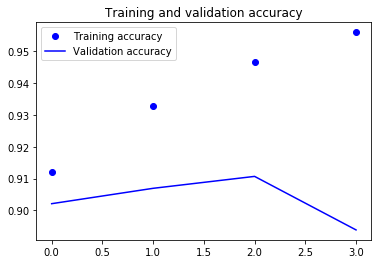

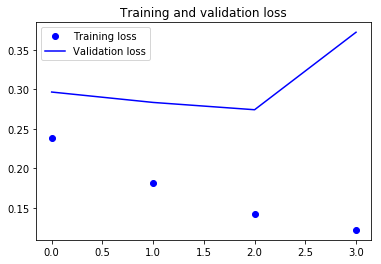

In [0]:
accuracy = classify_train.history['acc']
val_accuracy = classify_train.history['val_acc']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
test_eval = full_model.evaluate(test_data, test_Y_one_hot, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

predicted_classes = full_model.predict(test_data)
print(predicted_classes.shape)

Test loss: 0.38649271811842917
Test accuracy: 0.8913
(10000, 10)


In [0]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
print(predicted_classes)
predicted_classes.shape, test_labels.shape

correct = np.where(predicted_classes==test_labels)[0]
print("Found %d correct labels" % len(correct))
# for i, correct in enumerate(correct[:9]):
#     plt.subplot(3,3,i+1)
#     plt.imshow(test_data[correct].reshape(28,28), cmap='gray', interpolation='none')
#     plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
#     plt.tight_layout()

[9 2 1 ... 8 1 5]
Found 8888 correct labels


In [0]:
incorrect = np.where(predicted_classes!=test_labels)[0]
print("Found %d incorrect labels" % len(incorrect))
# for i, incorrect in enumerate(incorrect[:9]):
#     plt.subplot(3,3,i+1)
#     plt.imshow(test_data[incorrect].reshape(28,28), cmap='gray', interpolation='none')
#     plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
#     plt.tight_layout()

Found 1112 incorrect labels


In [0]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.83      0.87      0.85      1000
     Class 1       1.00      0.97      0.98      1000
     Class 2       0.89      0.86      0.88      1000
     Class 3       0.88      0.93      0.90      1000
     Class 4       0.82      0.90      0.86      1000
     Class 5       0.99      0.98      0.98      1000
     Class 6       0.80      0.69      0.74      1000
     Class 7       0.97      0.94      0.96      1000
     Class 8       0.98      0.98      0.98      1000
     Class 9       0.94      0.98      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks

import numpy as np
# from preprocessing import load_subject_eeg, eeg_to_3d, balanced_subsample, reverse_coeffs 
from utils import load_subject_eeg, eeg_to_3d, balanced_subsample, reverse_coeffs 

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd

def data_wrangler(data_type, subject_id):
	epoch = 4096
	if data_type == 'words':
		data, labels = load_subject_eeg(subject_id, vowels=False)
		n_chan = len(data)
		data = eeg_to_3d(data, epoch, int(data.shape[1] / epoch), n_chan).astype(np.float32)
		labels = labels.astype(np.int64)
	elif data_type == 'vowels':
		_, data, _, labels = load_subject_eeg(subject_id, vowels=True)
		n_chan = len(data)
		data = eeg_to_3d(data, epoch, int(data.shape[1] / epoch), n_chan).astype(np.float32)
		labels = labels.astype(np.int64)
	elif data_type == 'all_classes':
		w_data, v_data, w_labels, v_labels = load_subject_eeg(subject_id, vowels=True)
		n_chan = len(w_data)
		words = eeg_to_3d(w_data, epoch, int(w_data.shape[1] / epoch), n_chan).astype(np.float32)
		vowels = eeg_to_3d(v_data, epoch, int(v_data.shape[1] / epoch), n_chan).astype(np.float32)
		data = np.concatenate((words, vowels), axis=0)
		labels = np.concatenate((w_labels, v_labels), axis=0).astype(np.int64)
	
	x = lambda a: a * 1e6
	data = x(data)
	
	if data_type == 'words': # zero-index the labels
		labels[:] = [x - 6 for x in labels]
	elif (data_type == 'vowels' or data_type == 'all_classes'):
		labels[:] = [x - 1 for x in labels]

	return data, labels

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [0]:
import pickle
!pip install mne
import mne
words_file = 'raw_array_ica.pickle'
with open(words_file, 'rb') as f:
            file = pickle.load(f)
data = file['raw_array'][:][0]
labels = file['labels']
epoch = 4096
n_chan = len(data)
data_type = 'words'
data = eeg_to_3d(data, epoch, int(data.shape[1] / epoch), n_chan).astype(np.float32)
labels = labels.astype(np.int64)
if data_type == 'words' or data_type == 'all_classes':
    data = data[:,:,768:1280]
elif data_type == 'vowels':
    data = data[:,:,512:1024]
labels[:] = [x - 6 for x in labels] 


In [0]:
train_data = data.reshape(-1, 6,512, 1).astype(np.float32)
#test_data = test_images.reshape(-1, 28,28, 1).astype(np.float32)
train_data.shape

(304, 6, 512, 1)

In [0]:
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [0]:
batch_size = 32
epochs = 40
inChannel = 1
x, y = 6, 512
input_img = Input(shape = (x, y, inChannel))
num_classes = 6

In [0]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 6, 512, 1)         0         
_________________________________________________________________
conv2d_200 (Conv2D)          (None, 6, 512, 32)        320       
_________________________________________________________________
batch_normalization_190 (Bat (None, 6, 512, 32)        128       
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 6, 512, 32)        9248      
_________________________________________________________________
batch_normalization_191 (Bat (None, 6, 512, 32)        128       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 3, 256, 32)        0         
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 3, 256, 64)        184

In [0]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 243 samples, validate on 61 samples
Epoch 1/40
243/243 [==============================] - 12s 49ms/step - loss: 250.4953 - val_loss: 248.4983
Epoch 2/40
243/243 [==============================] - 1s 3ms/step - loss: 244.7372 - val_loss: 248.2414
Epoch 3/40
243/243 [==============================] - 1s 3ms/step - loss: 244.5502 - val_loss: 248.0455
Epoch 4/40
243/243 [==============================] - 1s 3ms/step - loss: 244.5219 - val_loss: 248.1115
Epoch 5/40
243/243 [==============================] - 1s 3ms/step - loss: 244.3393 - val_loss: 247.9984
Epoch 6/40
243/243 [==============================] - 1s 3ms/step - loss: 244.4538 - val_loss: 247.9728
Epoch 7/40
243/243 [==============================] - 1s 3ms/step - loss: 244.3263 - val_loss: 248.1330
Epoch 8/40
243/243 [==============================] - 1s 3ms/step - loss: 244.2865 - val_loss: 250.6440
Epoch 9/40
243/243 [==============================] - 1s 3ms/step - loss: 244.3842 - val_loss: 247.9663
Epoch 10/40
243/2

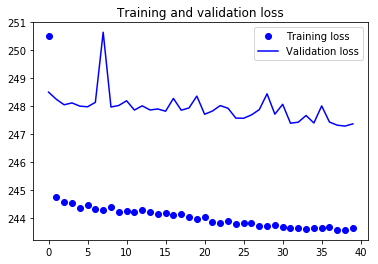

In [0]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(40)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
autoencoder.save_weights('autoencoder.h5')

In [0]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(labels)
#test_Y_one_hot = to_categorical(valid_ground)

# Display the change for category label using one-hot encoding
print('Original label:', labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 3
After conversion to one-hot: [0. 0. 0. 1. 0. 0.]


In [0]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((243, 6, 512, 1), (61, 6, 512, 1), (243, 6), (61, 6))

In [0]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4
  
def fc(enco):
  flat = Flatten()(enco)
  den = Dense(128, activation='relu')(flat)
  out = Dense(num_classes, activation='softmax')(den)
  return out

In [0]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [0]:
full_model.get_weights()[0][1]

array([[[-0.13484325,  0.09398295,  0.08922905, -0.13416083,
          0.08821231,  0.07737326, -0.06265058,  0.04321638,
         -0.14164673,  0.00667226, -0.07583974, -0.12094048,
          0.09955121, -0.1146613 , -0.06305849,  0.01876014,
          0.14105906, -0.06303285, -0.02069305,  0.06145287,
          0.13977903,  0.12725869,  0.018158  ,  0.07867987,
          0.02644461, -0.00069783, -0.04468967,  0.05071839,
         -0.06820734,  0.11826859, -0.03283694,  0.14059804]],

       [[ 0.04865379, -0.08428735,  0.13812955,  0.06984579,
          0.13956614,  0.12359103, -0.0408438 ,  0.05499064,
          0.02734514,  0.12609036, -0.10594746,  0.12850231,
         -0.11551043,  0.07582011, -0.04930169, -0.12849681,
         -0.0167097 , -0.05392137, -0.00226988, -0.03664307,
          0.09855723,  0.05151938,  0.13340081,  0.15148471,
         -0.03499214, -0.08503877, -0.03566308, -0.05799597,
         -0.13379866,  0.04036511, -0.08787024, -0.08111975]],

       [[ 0.059398

In [0]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [0]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [0]:
full_model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 6, 512, 1)         0         
_________________________________________________________________
conv2d_215 (Conv2D)          (None, 6, 512, 32)        320       
_________________________________________________________________
batch_normalization_204 (Bat (None, 6, 512, 32)        128       
_________________________________________________________________
conv2d_216 (Conv2D)          (None, 6, 512, 32)        9248      
_________________________________________________________________
batch_normalization_205 (Bat (None, 6, 512, 32)        128       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 3, 256, 32)        0         
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 3, 256, 64)        184

In [0]:
classify_train = full_model.fit(train_X[:200], train_label[:200], batch_size=64,epochs=40,verbose=1,validation_data=(train_X[200:], train_label[200:]))

Train on 200 samples, validate on 43 samples
Epoch 1/40
200/200 [==============================] - 10s 49ms/step - loss: 6.8587 - acc: 0.1650 - val_loss: 12.0594 - val_acc: 0.1628
Epoch 2/40
200/200 [==============================] - 0s 930us/step - loss: 4.5046 - acc: 0.5850 - val_loss: 13.3998 - val_acc: 0.0698
Epoch 3/40
200/200 [==============================] - 0s 884us/step - loss: 3.4374 - acc: 0.7450 - val_loss: 13.8497 - val_acc: 0.0698
Epoch 4/40
200/200 [==============================] - 0s 816us/step - loss: 2.7326 - acc: 0.8100 - val_loss: 13.4708 - val_acc: 0.0465
Epoch 5/40
200/200 [==============================] - 0s 800us/step - loss: 2.6427 - acc: 0.8250 - val_loss: 13.8396 - val_acc: 0.0930
Epoch 6/40
200/200 [==============================] - 0s 777us/step - loss: 2.7114 - acc: 0.8150 - val_loss: 13.7161 - val_acc: 0.0930
Epoch 7/40
200/200 [==============================] - 0s 805us/step - loss: 2.4097 - acc: 0.8400 - val_loss: 13.8682 - val_acc: 0.1163
Epoch 8/40

In [0]:
full_model.save_weights('autoencoder_classification.h5')

In [0]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [0]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [0]:
classify_train = full_model.fit(train_X[:200], train_label[:200], batch_size=64,epochs=40,verbose=1,validation_data=(train_X[200:], train_label[200:]))

Train on 200 samples, validate on 43 samples
Epoch 1/40
200/200 [==============================] - 11s 56ms/step - loss: 2.1772 - acc: 0.8650 - val_loss: 13.0640 - val_acc: 0.1163
Epoch 2/40
200/200 [==============================] - 0s 2ms/step - loss: 2.2122 - acc: 0.8500 - val_loss: 11.9515 - val_acc: 0.1163
Epoch 3/40
200/200 [==============================] - 0s 2ms/step - loss: 2.4789 - acc: 0.8050 - val_loss: 11.5875 - val_acc: 0.1628
Epoch 4/40
200/200 [==============================] - 0s 2ms/step - loss: 2.2482 - acc: 0.8200 - val_loss: 12.1495 - val_acc: 0.1163
Epoch 5/40
200/200 [==============================] - 0s 2ms/step - loss: 2.4189 - acc: 0.8250 - val_loss: 12.7892 - val_acc: 0.1163
Epoch 6/40
200/200 [==============================] - 0s 2ms/step - loss: 2.3726 - acc: 0.8100 - val_loss: 12.7268 - val_acc: 0.1395
Epoch 7/40
200/200 [==============================] - 0s 2ms/step - loss: 2.2207 - acc: 0.8100 - val_loss: 12.9783 - val_acc: 0.1163
Epoch 8/40
200/200 [==

In [0]:
full_model.save_weights('classification_complete.h5')

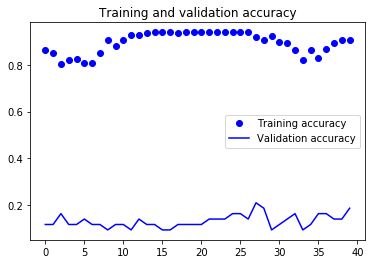

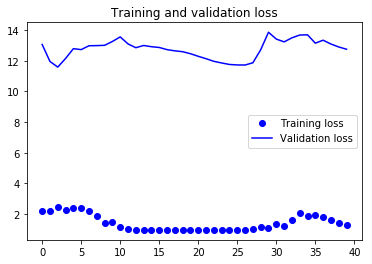

In [0]:
accuracy = classify_train.history['acc']
val_accuracy = classify_train.history['val_acc']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
test_eval = full_model.evaluate(valid_X, valid_label, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

predicted_classes = full_model.predict(valid_X)

Test loss: 13.03644893208488
Test accuracy: 0.14754098678221467


In [0]:
print(predicted_classes)

3


In [0]:
print(predicted_classes[0])
predicted_classes1 = np.argmax(predicted_classes, axis=1)
print(to_categorical(predicted_classes1))
print(valid_label)

[3.5413085e-14 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00
 0.0000000e+00]
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1.

In [0]:
np.where(predicted_classes1==valid_label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(array([], dtype=int64),)

In [0]:
#predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

predicted_classes.shape, test_labels.shape

correct = np.where(to_categorical(predicted_classes1)==valid_label)[0]
print("Found %d correct labels" % len(correct))

Found 266 correct labels
